# Marketing A/B Testing

A/B testing is a method used to **compare two versions of a website or app** to determine which one performs better. It involves randomly showing users version A or version B and then measuring a specific metric, such as click-through rate or conversion rate, to determine which version is more successful. A/B testing is commonly used in digital product development to optimize user experience and increase conversions.


<p><img src="https://images.unsplash.com/photo-1616418625172-c607e16733ca?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=2069&q=80" alt></p>

Using data from an anonymous company, <a href="https://www.kaggle.com/datasets/faviovaz/marketing-ab-testing"> collected on Kaggle </a>, we will analyze the impact of the implementaion on the landing page of a new website feature. 
The test was run for two weeks. Now the company is trying to determine what strategy to adopt: 
- A. Keep this new feature 
- B. Keep the old version 

In [1]:
#Libraries 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport

## 1. The AB-test data

<p>Below is a description of this data set:</p>
<ul>
<li><code>Campaign Name</code> - target campaign for ad landing page</li>
<li><code>Spend [USD]</code> - the amount of money spent on advertising in the campaign</li>
<li><code># of Impressions</code> - the number of people who viewed the ad in the campaign (contains repeated viewing of the same person for the ad).</li>
<li><code>Reach:</code> - the number of unique people who saw the ad in the campaign. 
<li><code># of Website Clicks</code> - the number of users who clicked on the website link in the campaign's advertisement. </li>
<li><code># of Searches</code> - the number of users who performed a search on the website </li>
<li><code># of View Content</code> -  number of users who have viewed product details. </li>
<li><code># of Add to Cart </code> -  number of users who have added the product to the cart. </li>
<li><code># of Add to Purchase </code> -  number of users who have purchased the product </li>
</ul>

In [2]:
# Load files
control_data = pd.read_csv('datasets/control_group.csv', sep=";")
test_data = pd.read_csv('datasets/test_group.csv', sep=';')

In [3]:
print(control_data.head())
print(test_data.head())

      Campaign Name       Date  Spend [USD]  # of Impressions     Reach  \
0  Control Campaign  1.08.2019         2280           82702.0   56930.0   
1  Control Campaign  2.08.2019         1757          121040.0  102513.0   
2  Control Campaign  3.08.2019         2343          131711.0  110862.0   
3  Control Campaign  4.08.2019         1940           72878.0   61235.0   
4  Control Campaign  5.08.2019         1835               NaN       NaN   

   # of Website Clicks  # of Searches  # of View Content  # of Add to Cart  \
0               7016.0         2290.0             2159.0            1819.0   
1               8110.0         2033.0             1841.0            1219.0   
2               6508.0         1737.0             1549.0            1134.0   
3               3065.0         1042.0              982.0            1183.0   
4                  NaN            NaN                NaN               NaN   

   # of Purchase  
0          618.0  
1          511.0  
2          372.0  
3   

## 2. Data Preparation

In a first step we explore the data.
The two data set for both campaigns are equal in number. But we notice that the data we have collected have some errors in colmuns names, types errors and null values for the contol data set.

In [4]:
control_report = ProfileReport(control_data, title = 'Control')
test_report = ProfileReport(test_data, title = 'Test')
test_report.compare(control_report)

Render HTML: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


In [5]:
# columns names
def to_clean(val):
    return val.strip().lower().replace("# ", "").replace("of ", "").replace(" ","_").replace("[usd]", "usd")

control_data.rename(columns=to_clean, inplace = True)
test_data.rename(columns=to_clean, inplace=True)

In [6]:
#merge data
campaign_data = control_data.merge(test_data, how='outer').sort_values(['date']).reset_index(drop= True)
campaign_data.head()

campaign_name        date  spend_usd  impressions    reach  \
0  Control Campaign   1.08.2019       2280      82702.0  56930.0   
1     Test Campaign   1.08.2019       3008      39550.0  35820.0   
2     Test Campaign  10.08.2019       2790      95054.0  79632.0   
3  Control Campaign  10.08.2019       2149     117624.0  91257.0   
4     Test Campaign  11.08.2019       2420      83633.0  71286.0   

   website_clicks  searches  view_content  add_to_cart  purchase  
0          7016.0    2290.0        2159.0       1819.0     618.0  
1          3038.0    1946.0        1069.0        894.0     255.0  
2          8125.0    2312.0        1804.0        424.0     275.0  
3          2277.0    2475.0        1984.0       1629.0     734.0  
4          3750.0    2893.0        2617.0       1075.0     668.0

In [7]:
# correct data type
campaign_data['date'] = pd.to_datetime(campaign_data['date'])


In [8]:
# null values 
campaign_data[campaign_data.isnull().any(axis= 1)]
campaign_data.dropna(inplace=True)

> 👉🏾 For the null values as they were all in a same row,  we choose to drop this row. 

## 3. EDA

### 3. 1 General metrics

In [9]:
#count number of campaigns
campaign_data.groupby(["campaign_name"])["campaign_name"].count()

campaign_name
Control Campaign    29
Test Campaign       30
Name: campaign_name, dtype: int64

In [10]:
#number of persons reached
people_reach = campaign_data.groupby(["campaign_name"])["reach"].sum()
people_reach_count = pd.concat([people_reach, 
               people_reach / people_reach.sum()] , keys=('counts','percentage'), axis=1)
people_reach_count

counts  percentage
campaign_name                          
Control Campaign  2576503.0    0.616204
Test Campaign     1604747.0    0.383796

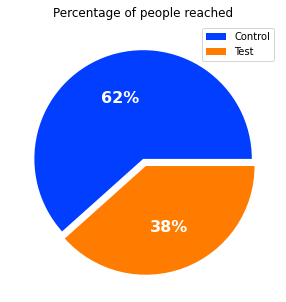

In [11]:
# plot percentage of people reached 
plt.rcParams['figure.figsize'] = [10, 5]
colors = sns.color_palette('bright')[0:2]

labels = ['Control', 'Test']

plt.pie(people_reach_count.percentage, 
        colors = colors, 
        autopct='%.0f%%', #number format 
        textprops={'fontsize': 16, 'color':'white', 'fontweight':'bold'}, #aesthetic for text
        explode = (0, 0.07)) #aesthetic for the pie chart

plt.title('Percentage of people reached')
plt.legend(labels, loc='best')
plt.show()

It can be seen that the campaigns were repeated approximately the same number of times. There are 29 for the test campaign since we removed the missing data. 

However, there is an imbalance in the number of people who saw the two campaigns. 62% of the targeted people are in the control group and 38% in the test group. Since there is a large difference, this may bias the results of the A/B test.

In a second step we want to study in more detail the different metrics that have been measured during this experimentation. 

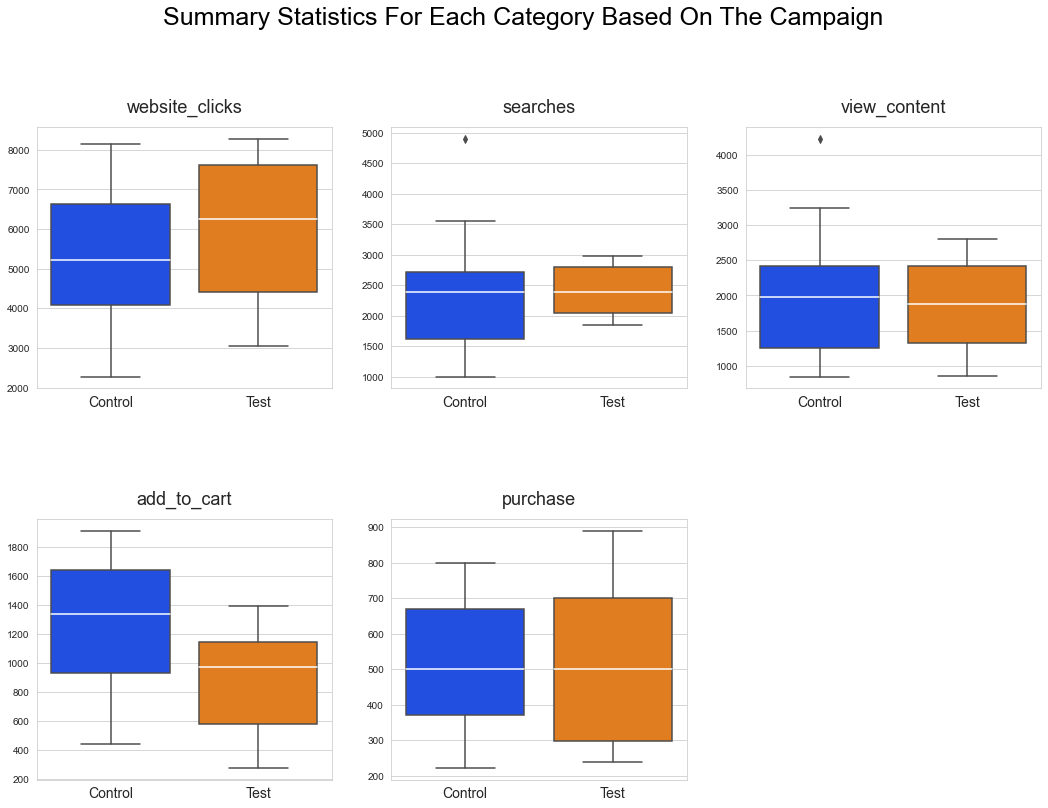

In [12]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(2,3, figsize=(18,12), sharex=False)

categories = ["website_clicks","searches", "view_content", "add_to_cart", "purchase"]

r=0
c=0

#plot for each categories a new boxplot
for cat in categories: 
    sns.boxplot(x='campaign_name', 
                y= cat, 
                data = campaign_data, 
                ax= ax[r,c], 
                palette=sns.color_palette('bright')[0:2], 
                medianprops=dict(color="white", alpha=1)) 
    
    ax[r,c].set_title(cat, fontsize=18, pad=15)
    ax[r,c].set_xlabel('')
    ax[r,c].set_ylabel('')
    ax[r,c].set_xticklabels( labels=["Control", "Test"], fontsize=14)
    
    #change subplot
    if c>=2:
        r+=1
        c=-1
    c+=1

plt.subplots_adjust(hspace = 0.5, wspace=0.2)
fig.suptitle("Summary Statistics For Each Category Based On The Campaign", fontsize=25, color="k", y=1.02)

# Delete the last subplot, indexing is zero based
fig.delaxes(ax[1,2])
   

In [13]:
campaign_data.groupby('campaign_name')["website_clicks","searches", "view_content", "add_to_cart", "purchase"].mean()

/var/folders/1r/7t449kpd1x144fxb4054tp700000gn/T/ipykernel_51645/2542183145.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  campaign_data.groupby('campaign_name')["website_clicks","searches", "view_content", "add_to_cart", "purchase"].mean()


website_clicks     searches  view_content  add_to_cart  \
campaign_name                                                              
Control Campaign     5320.793103  2221.310345   1943.793103  1300.000000   
Test Campaign        6032.333333  2418.966667   1858.000000   881.533333   

                    purchase  
campaign_name                 
Control Campaign  522.793103  
Test Campaign     521.233333

We observe that the campaigns have different effects on the users of the website. 
The main differences are in the number of clicks generated by the campaigns. On average the test campaign generates 6032 clicks per day, which is **13% more clicks** than a classic campaign.
We also notice a big difference in the number of additions to the shopping cart by potential customers. We count 1300 users per day on average in the control campaign where for the test campaign the average is only 881, **a difference of -32%**.


### 3.2 How much was spent ? 



Text(0, 0.5, 'Total spent (in USD)')

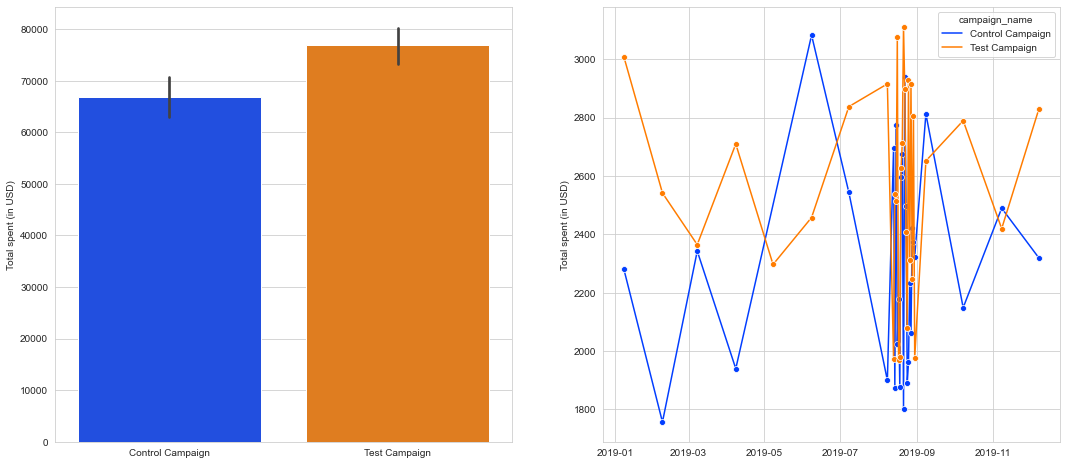

In [38]:
#plot spending overtime and per campaign
sns.set_style("whitegrid")
fig, ax = plt.subplots(1,2, figsize=(18,8), sharex=False)
colors = palette=sns.color_palette('bright')[0:2]

sns.barplot(data=campaign_data, y='spend_usd', x='campaign_name', estimator=sum, ax= ax[0], palette=colors)
sns.lineplot(data=campaign_data, x='date', y='spend_usd', hue='campaign_name', marker="o", ax= ax[1], palette= colors)

#aesthetic
ax[0].set_xlabel('')
ax[0].set_ylabel('Total spent (in USD)')

ax[1].set_xlabel('')
ax[1].set_ylabel('Total spent (in USD)')


The company spent more money on the test campaign, but does this cost really influence user behavior? 

First we will see if there are correlations between the cost and the other metrics 
and then we will look at the cost of acquisition per customer. 

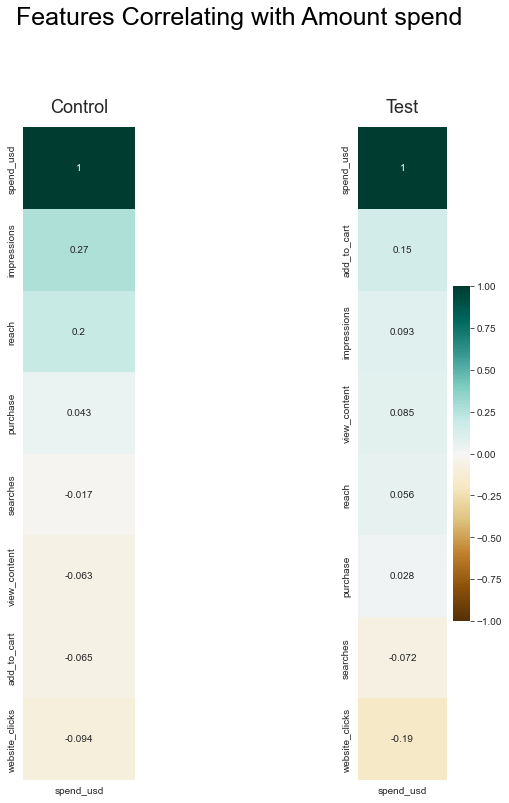

In [15]:
# correlation matrix
cont_corr_data = campaign_data[campaign_data['campaign_name']=='Control Campaign'].corr()[['spend_usd']]\
    .sort_values(by='spend_usd', ascending= False)
test_corr_data = campaign_data[campaign_data['campaign_name']=='Test Campaign'].corr()[['spend_usd']]\
    .sort_values(by='spend_usd', ascending= False)

#plot correlation matrix
fig, ax = plt.subplots(1,2, figsize=(8,12))
heatmap = sns.heatmap(cont_corr_data, vmin=-1, vmax=1, annot=True, cmap='BrBG', ax=ax[0], cbar=False)
heatmap = sns.heatmap(test_corr_data, vmin=-1, vmax=1, annot=True, cmap='BrBG', ax=ax[1])

#aesthetic
ax[0].set_title('Control', fontsize=18, pad=15)
ax[1].set_title('Test', fontsize=18, pad=15)
fig.suptitle('Features Correlating with Amount spend', fontsize=25, color="k", y=1.02)
plt.subplots_adjust(hspace = 1, wspace=2)

 There is **no real correlation between spending and customer behavior**. We observe:
 -  positive relationship between the number of impressions and the money spent (in the case of the control campaign)
 -  a slight positive effect on the number of people adding products to their shopping cart (test condition) 
 - and a negative correlation between the number of clicks and spending (test condition).

 **Customer Acquisition Cost**

 Customer Acquisition Cost (CAC) is a metric that measures the cost a business incurs to acquire a new customer. It is calculated by dividing the total costs associated with sales and marketing efforts (such as advertising, sales salaries, and commissions) by the number of new customers acquired during that same time period.

 Here we will take into account only the costs related to the two campaigns : 

In [16]:
#CAC
campaign_data.groupby('campaign_name')['spend_usd'].sum()/campaign_data.groupby('campaign_name')['purchase'].sum()

campaign_name
Control Campaign    4.407229
Test Campaign       4.917312
dtype: float64

The costs per acquisition are quite similar for both campaigns, although the cost of the test camp is slightly higher. 

Is it worth the extra investment? 

To answer this question, we will focus on two strategically decisive metrics to evaluate the effectiveness of a campaign: the click through rate and the conversion rate (these terms are defined below)

# 4.Click-through rate

Click-through rate (CTR) is a metric used in digital marketing to measure the effectiveness of an advertisement or marketing campaign. It is calculated by dividing the number of clicks on an ad by the number of times it was displayed (impressions). CTR provides insight into the engagement level of the audience and is used to determine the success of an online advertising effort. A high CTR indicates that an ad is resonating with its intended audience and is considered an effective campaign.In this section, we will focus solely on CTR in order to determine which of the two campaigns seems to be the most effective according to this measure.


In [17]:
campaign_data['ctr']= campaign_data["website_clicks"]/campaign_data["impressions"]

In [18]:
campaign_data.groupby('campaign_name')['ctr'].mean()

campaign_name
Control Campaign    0.050959
Test Campaign       0.102423
Name: ctr, dtype: float64

Text(0.5, 1.0, 'Website Clicks vs Impressions')

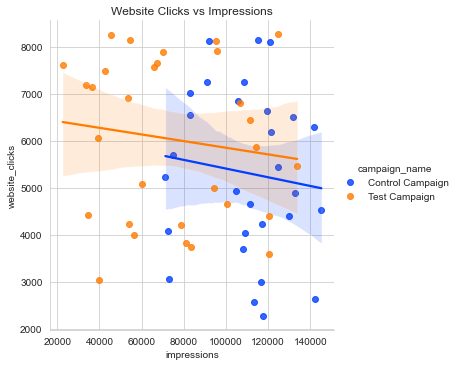

In [32]:
sns.lmplot(data = campaign_data, 
        x='impressions', 
        y='website_clicks', 
        hue='campaign_name', 
        palette=colors)
plt.title('Website Clicks vs Impressions')

Text(0.5, 1.0, 'Ctr rate per campaign')

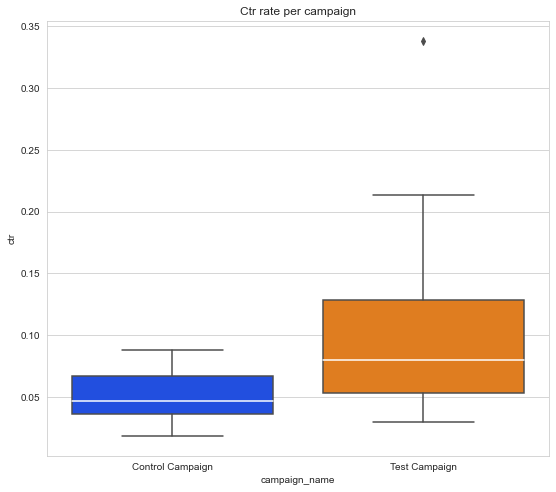

In [20]:
plt.rcParams['figure.figsize'] = [9, 8]
sns.set_style("whitegrid")
sns.boxplot(data = campaign_data, y='ctr', x='campaign_name', 
                medianprops=dict(color="white", alpha=1), 
                palette=colors
                )
plt.title('Ctr rate per campaign')

We observe a better CTR for the test campaign than for the control campaign. This rate even doubles ! 
Should we be confident in the difference ? 

#### Statistical Test with bootstrapping

Bootstrapping is a statistical technique that involves resampling data from a single sample with replacement to generate multiple new samples, called bootstrap samples. The goal of bootstrapping is to use these bootstrap samples to estimate the distribution of a population statistic that is not easily estimated from the original sample, such as the standard deviation or confidence intervals for a mean.

Bootstrapping is often used in place of traditional statistical methods, such as the normal distribution or t-distribution, when the sample size is small or the underlying distribution is not well understood. By generating multiple bootstrap samples and aggregating the results, bootstrapping can provide a more robust estimate of the population statistic.

<AxesSubplot:ylabel='Density'>

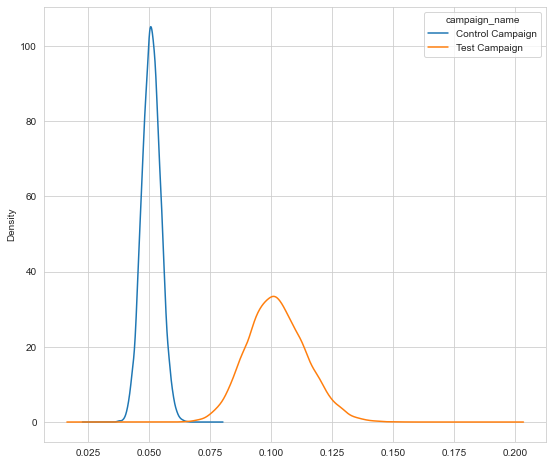

In [41]:
# Creating an list with bootstrapped means for each AB-group
boot_ctr = []
for i in range(10000):
    boot_mean = campaign_data.sample(frac=1, replace = True).groupby('campaign_name')['ctr'].mean()
    boot_ctr.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_ctr = pd.DataFrame(boot_ctr)
    
# A Kernel Density Estimate plot of the bootstrap distributions
boot_ctr.plot(kind='kde')

These two distributions above represent the bootstrap uncertainty over what the CTR could be for the two AB-groups. Just eyeballing this plot, we can see that there seems to be some evidence of a difference.


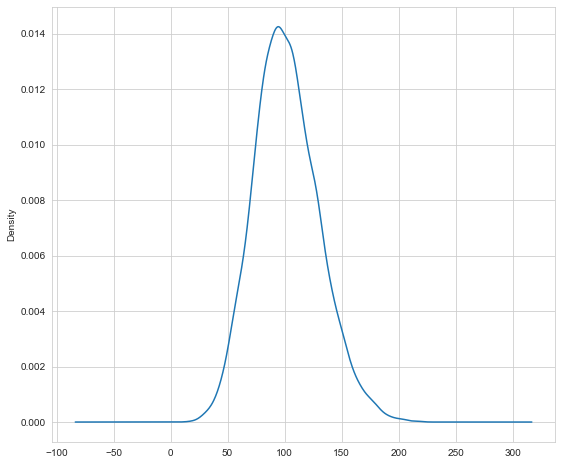

In [22]:
# Adding a column with the % difference between the two AB-groups
boot_ctr['diff'] = (boot_ctr['Test Campaign']-boot_ctr['Control Campaign'])/boot_ctr['Control Campaign']*100

# Ploting the bootstrap % difference
ax = boot_ctr['diff'].plot(kind='kde')

In [23]:
# Calculating the probability that 1-day retention is greater when the gate is at level 30
prob = (boot_ctr['diff'] > 0).mean()

# Pretty printing the probability
print('{:.1%}'.format(prob))

100.0%


The probabilty that the differnce is above 0% equals to 100%. there is a very high probability that the CTR is better for the test campaign than the control one. 

# 5.Conversion Rate

Conversion rate in digital marketing refers to the percentage of website visitors who take a desired action, such as making a purchase, filling out a form, or subscribing to a newsletter. It's a crucial metric that helps businesses determine the effectiveness of their marketing efforts and website design.

A high conversion rate indicates that a significant portion of website visitors are taking the desired action, and a low conversion rate may indicate that improvements are needed in areas such as website design, marketing strategy, or product offerings. By tracking conversion rates, businesses can make data-driven decisions to improve their website and marketing efforts to increase sales and revenue.

In this exercise, we consider the conversion rate as the total number of people who made purchases compared to the total number of people who saw the different ads.  We choose the number of people who saw the ad here because it counts the number of unique users, where for the other metrics it is not necessarily specified. 
In this way we can measure if one campaign influences user behavior more than another. 

In [24]:
campaign_data['conversion_rate']= campaign_data["purchase"]/campaign_data["reach"]

In [25]:
campaign_data.groupby('campaign_name')['conversion_rate'].mean()

campaign_name
Control Campaign    0.006332
Test Campaign       0.014130
Name: conversion_rate, dtype: float64

Text(0.5, 1.0, 'Purchase vs Reach')

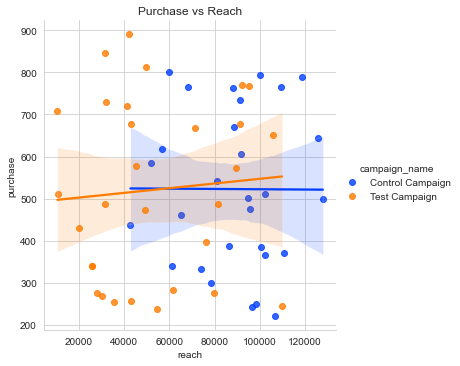

In [34]:
sns.lmplot(data = campaign_data, x='reach', y='purchase', 
            hue='campaign_name', 
            palette=colors)
plt.title('Purchase vs Reach')

<AxesSubplot:xlabel='campaign_name', ylabel='conversion_rate'>

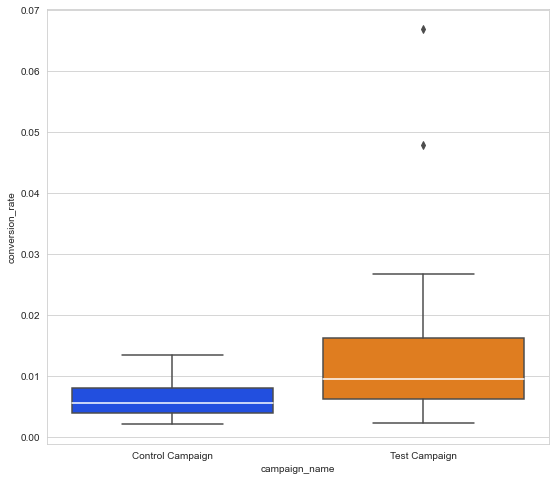

In [27]:
plt.rcParams['figure.figsize'] = [9, 8]
sns.set_style("whitegrid")
sns.boxplot(data = campaign_data, y='conversion_rate', x='campaign_name', 
            medianprops=dict(color="white", alpha=1), 
            palette=colors)

As for the CTR, we observe a difference in favor of the test campaign. People who have seen this campaign seem to be more inclined to make purchases on the site. Is this difference statistically significant? 
We will also use the bootstrap method to find out. 

## Statistical Test with bootstrap

<AxesSubplot:ylabel='Density'>

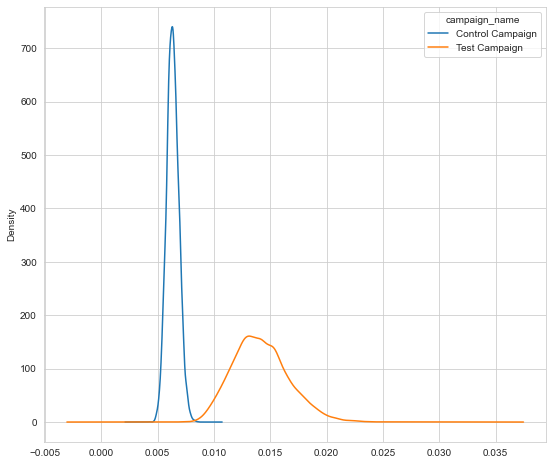

In [28]:
# Creating an list with bootstrapped means for each AB-group
boot_cr = []
for i in range(10000):
    boot_mean = campaign_data.sample(frac=1, replace = True).groupby('campaign_name')['conversion_rate'].mean()
    boot_cr.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_cr = pd.DataFrame(boot_cr)
    
# A Kernel Density Estimate plot of the bootstrap distributions
boot_cr.plot(kind='kde')

In [29]:
boot_cr

campaign_name    Control Campaign  Test Campaign
conversion_rate          0.005402       0.013235
conversion_rate          0.006045       0.013230
conversion_rate          0.007401       0.013719
conversion_rate          0.006485       0.014508
conversion_rate          0.006363       0.012095
...                           ...            ...
conversion_rate          0.005824       0.013187
conversion_rate          0.007067       0.011746
conversion_rate          0.006301       0.015106
conversion_rate          0.006150       0.017184
conversion_rate          0.006740       0.012456

[10000 rows x 2 columns]

From the graph it is clear that there is a difference, let's zoom in on it. 

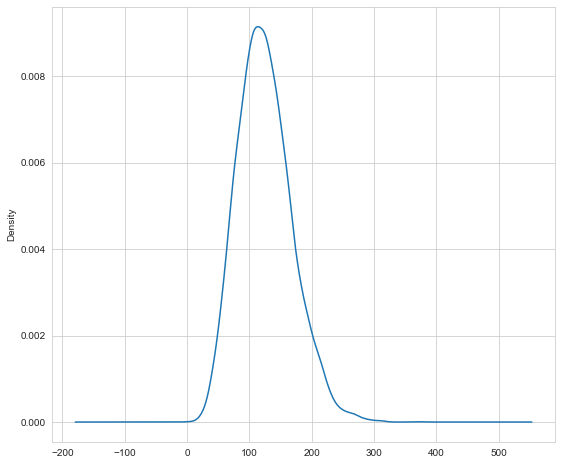

In [30]:
# Adding a column with the % difference between the two AB-groups
boot_cr['diff'] = (boot_cr['Test Campaign']-boot_cr['Control Campaign'])/boot_cr['Control Campaign']*100

# Ploting the bootstrap % difference
ax = boot_cr['diff'].plot(kind='kde')

In [31]:
# Calculating the probability that 1-day retention is greater when the gate is at level 30
prob = (boot_cr['diff'] > 0).mean()

# Pretty printing the probability
print('{:.1%}'.format(prob))

100.0%


As for the CTR, we observe that the probability that the difference is greater than 0% is equal to 100%. There is a very high probability that the conversion rate is better for the test campaign than for the control campaign.

# Conclusion 

Our study shows strong indications that the test campaign is performing very well on the metrics studied, namely the rate of people clicking through to the website and the rate of conversation between the time people see the ad and actually buy a product. 
These good rates can be explained by a campaign that seems to **attract the attention of prospects** and that **influences their behavior over time**. 
So **adopting the test campaign seems to be a good strategy**. 

These results are nuanced. First of all, we could demonstrate that this campaign has a higher cost than a classic campaign. Secondly, other metrics that have not been taken into consideration here should be considered and open up other avenues for exploration. 
